In [314]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy as sp
import matplotlib.gridspec as gridspec
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch
import time
from tabulate import tabulate

import sys 
sys.path.append("../src/unicycleSourceFiles")
import importlib
import models
import unicycle
import config
import trainer
import utils
importlib.reload(models)
importlib.reload(unicycle)
importlib.reload(config)
importlib.reload(trainer)
importlib.reload(utils)
from models import DeepONetProjected, FNOProjected, FNOGRUNet, DeepONetGRUNet, ml_predictor
from unicycle import simulate_system_const_delay, predictor_const_delay
from config import ModelConfig, SimulationConfig
from trainer import model_trainer, evaluate_train_performance, evaluate_model    
from utils import plot_trajectory, count_parameters, plot_trajectory_with_errors

In [202]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

#### Build general simulation settings configs

In [130]:
dynamics_config = {
    "T": 10, # Simulation final time
    "dt": 0.01, # Simulation step size
    "D": 1, # Delay length
    "dx": 0.01 # Simulation for propagating the transport PDE
}

dataset_config = {
    "batch_size": 32,  # batch_size
    "test_size": 0.1, # Percentage of data to use for testing
    "random_state": 1, # random state for train test split
    "device_name": "cuda" # Use cuda or CPU
}

sim_config = SimulationConfig({"dynamics": dynamics_config, "dataset": dataset_config})

#### Build a dataset
(optional) Can load a dataset from hugging face

In [131]:
# build a dataset for unicycle for const delay. Vary over both initial conditions and delay
num_trajs = 100
sample_rate = 200
dt = sim_config.dt
T = sim_config.T
D = sim_config.D
dx = sim_config.dx
x = sim_config.x
nx = len(x)
t = sim_config.t
nt = len(t)
index = 0

inputs = np.zeros((num_trajs*sample_rate, nx, 6))
outputs = np.zeros((num_trajs*sample_rate, nx, 3))
for i in range(num_trajs):
    if i % 5 == 0:
        print(i)
    # CONTROLS THE INITAL CONDITION AND DEVIATION TO BUILD DATASET
    init_cond = np.array([1, 1, 1]) + np.random.uniform(-0.2, 0.2, size=3)
    # CONTROLS THE DELAY DEVIATION
    D = np.random.uniform(1, 1.1)
    u_delay, control_delay, pde, predictions = simulate_system_const_delay(init_cond, dt, T, dx, D, predictor_const_delay, None)
    sample_locs = random.sample(range(0, nt), sample_rate)
    for sample in sample_locs:
        delays = np.full(nx, D).reshape(nx, 1)
        states = np.tile(u_delay[sample], (nx, 1))
        inputs[index] = np.hstack([delays, states, pde[sample]])
        outputs[index] = predictions[sample]
        index += 1

np.save('../datasets/UnicycleConstDelayDataset/inp_dataset_const.npy', inputs)
np.save('../datasets/UnicycleConstDelayDataset/out_dataset_const.npy', outputs)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


#### Load model configs

In [132]:
# Configure FNO
train_config_fno = {
    "model_filename": "fno", # File to save/load trained model
    "model_type": "FNO",  # Specifies what model we are loading
    "epochs": 100,  # Specifies the number of epochs to train model
    "gamma": 0.93, # Specifies the learning rate scheduling parameter
    "learning_rate": 1e-3, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_fno = {
    "hidden_size": 16, # Specifies number of neurons per layer
    "modes": 12, # Specifies number of fourier nodes to use
    "num_layers": 2, # Specifies number of layers
}

fno_config = ModelConfig({"train": train_config_fno, "FNO": architecture_config_fno})

# Build archtiecture.
fno_config.update_config(input_channel=6, output_channel=3)
fno = FNOProjected(fno_config.hidden_size, fno_config.num_layers, fno_config.modes, fno_config.input_channel, fno_config.output_channel)

In [134]:
# Configure DeepONet
train_config_deeponet = {
    "model_filename": "deeponet", # File to save/load trained model
    "model_type": "DeepONet",  # Specifies what model we are loading
    "epochs": 100,  # Specifies the number of epochs to train model
    "gamma": 0.93, # Specifies the learning rate scheduling parameter
    "learning_rate": 1e-3, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_deeponet = {
    "hidden_size": 32, # Specifies number of neurons per layer
    "num_layers": 3, # Specifies number of layers,
    "dim_x": 1, # Specifies the input dimension,
}

deeponet_config = ModelConfig({"train": train_config_deeponet, "DeepONet": architecture_config_deeponet})
deeponet_grid = np.arange(0, sim_config.D, sim_config.dt/6).astype(np.float32)
deeponet_grid = torch.from_numpy(deeponet_grid.reshape((len(deeponet_grid), 1))).to(sim_config.device)
deeponet_config.update_config(input_channel=deeponet_grid.shape[0], output_channel=sim_config.nD*3)
deeponet = DeepONetProjected(deeponet_config.dim_x, deeponet_config.hidden_size, deeponet_config.num_layers, \
                            deeponet_config.input_channel, deeponet_config.output_channel, \
                            deeponet_grid)

In [135]:
# Configure FNO GRU
train_config_fno_gru = {
    "model_filename": "fnogru", # File to save/load trained modelTry this:
    "model_type": "FNO+GRU",  # Specifies what model we are loading
    "epochs": 100,  # Specifies the number of epochs to train model
    "gamma": 0.93, # Specifies the learning rate scheduling parameter
    "learning_rate": 1e-3, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_fno_gru = {
    "fno_hidden_size": 16, # Specifies number of neurons per layer FNO
    "modes": 12, # Specifies number of fourier nodes to use
    "fno_num_layers": 2, # Specifies number of layers FNO
    "gru_hidden_size": 16, # Specifies number of neurons per layer GRU
    "gru_num_layers": 2
}

fno_gru_config = ModelConfig({"train": train_config_fno_gru, "FNOGRU": architecture_config_fno_gru})

# Build architecture. Note that input and output channels depend on DOF chosen and so we update here.
fno_gru_config.update_config(input_channel=6, output_channel=3)
fno_gru = FNOGRUNet(fno_gru_config.fno_num_layers, fno_gru_config.gru_num_layers, fno_gru_config.fno_hidden_size, \
          fno_gru_config.gru_hidden_size, fno_gru_config.modes, fno_gru_config.input_channel, \
          fno_gru_config.output_channel)

In [167]:
# Configure DeepONet GRU
train_config_deeponet_gru = {
    "model_filename": "deeponetgru", # File to save/load trained model
    "model_type": "DeepONet+GRU",  # Specifies what model we are loading
    "epochs": 100,  # Specifies the number of epochs to train model
    "gamma": 0.93, # Specifies the learning rate scheduling parameter
    "learning_rate": 5e-4, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_deeponet_gru = {
    "deeponet_hidden_size": 32, # Specifies number of neurons per layer
    "deeponet_num_layers": 3, # Specifies number of layers,
    "dim_x": 1, # Specifies the input dimension,
    "gru_num_layers": 3, 
    "gru_hidden_size": 32,
}

deeponet_gru_config = ModelConfig({"train": train_config_deeponet_gru, "DeepONetGRU": architecture_config_deeponet_gru})

# Build archtiecture. Note that input and output channels depend on DOF chosen and so we update here.
deeponet_gru_grid = np.arange(0, sim_config.D, sim_config.dt/6).astype(np.float32)
deeponet_gru_grid = torch.from_numpy(deeponet_gru_grid.reshape((len(deeponet_gru_grid), 1))).to(sim_config.device)
deeponet_gru_config.update_config(input_channel=deeponet_gru_grid.shape[0], output_channel=sim_config.nD*3)
deeponet_gru = DeepONetGRUNet(deeponet_gru_config.dim_x, deeponet_gru_config.deeponet_num_layers, deeponet_gru_config.gru_num_layers, \
                         deeponet_gru_config.deeponet_hidden_size, deeponet_gru_config.gru_hidden_size, deeponet_gru_config.input_channel, \
                         deeponet_gru_config.output_channel, deeponet_gru_grid)

In [168]:
print(f"{'Model':<15} {'Number of parameters':<20}")
print(f"{'FNO':<15} {count_parameters(fno):<12}")
print(f"{'DeepONet':<15} {count_parameters(deeponet):<12}")
print(f"{'FNO GRU':<15} {count_parameters(fno_gru):<12}")
print(f"{'DeepONet GRU':<15} {count_parameters(deeponet_gru):<12}")

Model           Number of parameters
FNO             7171        
DeepONet        1102909     
FNO GRU         8838        
DeepONet GRU    1119232     


### Train our models
(Optional) Models can be downloaded from hugging face. Should be fast for unicycle problem with a GPU.
Uncomment below to train. May need to be careful with memory and release kernel memory between each train. 

In [169]:
# Prepare dataset
inputs = np.load("../datasets/UnicycleConstDelayDataset/inp_dataset_const.npy").astype(np.float32)
outputs = np.load("../datasets/UnicycleConstDelayDataset/out_dataset_const.npy").astype(np.float32)

x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=sim_config.test_size, random_state=sim_config.random_state)
x_train = torch.from_numpy(x_train).to(sim_config.device)
x_test = torch.from_numpy(x_test).to(sim_config.device)
y_train = torch.from_numpy(y_train).to(sim_config.device)
y_test = torch.from_numpy(y_test).to(sim_config.device)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=sim_config.batch_size, shuffle=True, generator=torch.Generator(device=sim_config.device))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=sim_config.batch_size, shuffle=False, generator=torch.Generator(device=sim_config.device))

Epoch Time Train Loss Test Loss
Total epochs 100
0 2.8721256256103516 0.015797733497035858 0.0014881522039927187
5 2.872636318206787 0.0002589421585610808 0.0002337688433943272
10 2.8642349243164062 0.00012092597996599957 0.00013382770039098676
15 2.862220287322998 8.899812914036566e-05 0.0001446690569984697
20 2.828514337539673 7.125819139601808e-05 8.81303607572576e-05
25 2.8009798526763916 6.218719135117027e-05 8.268638541469247e-05
30 2.79377818107605 5.624081411945458e-05 7.557704673903544e-05
35 2.788175344467163 5.176479235273595e-05 7.205381108279753e-05
40 2.7972021102905273 4.92097816353163e-05 6.947916009512339e-05
45 2.794935703277588 4.738989282066712e-05 6.826366523686346e-05
50 2.7945353984832764 4.606775343921623e-05 6.738418709400797e-05
55 2.8436295986175537 4.508076931714274e-05 6.729679247770931e-05
60 2.846773147583008 4.448147886171652e-05 6.585723915324909e-05
65 2.8431239128112793 4.405891329590423e-05 6.538319268570159e-05
70 2.8703322410583496 4.37423061874717

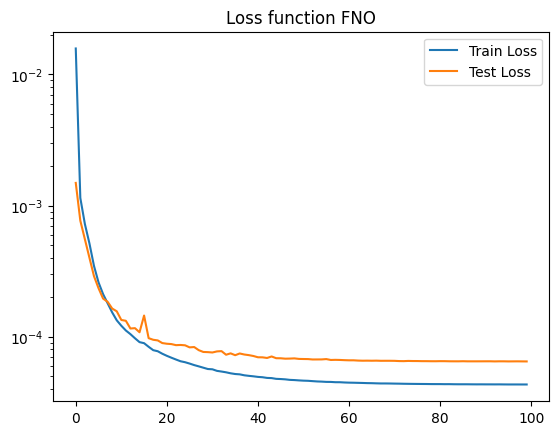

Final Testing Loss: 6.457928356255815e-05
Final Training Loss: 4.3073158568351015e-05


<Figure size 640x480 with 0 Axes>

In [139]:
# Train FNO
fno, fno_train_loss_arr, fno_test_loss_arr = model_trainer(fno, trainData, testData, \
                                                         fno_config.epochs, sim_config.batch_size, \
                                                         fno_config.gamma, fno_config.learning_rate,\
                                                         fno_config.weight_decay,\
                                                         "../models/UnicycleConstDelayModels/fno")
evaluate_train_performance(fno, fno_config.model_type, fno_train_loss_arr, fno_test_loss_arr)

Epoch Time Train Loss Test Loss
Total epochs 100
0 1.2458221912384033 0.006636024065556412 0.002035419838244302
5 1.2326154708862305 0.0005645002340031523 0.0005707942521742856
10 1.4869399070739746 0.0004673886321609936 0.0005642457385658331
15 1.234745740890503 0.00020598927910551743 0.00020184128452600572
20 1.2339129447937012 0.00014536048166352932 0.00016088732768872028
25 1.240617036819458 0.00011753816044873158 0.00013586697587881992
30 1.2569000720977783 9.918182153581145e-05 0.00012738419184368842
35 1.2604660987854004 8.872797332201496e-05 0.00010955222329819604
40 1.2621898651123047 7.980789847888171e-05 0.00010350766093497874
45 1.2583379745483398 7.53229607352866e-05 9.913483752045847e-05
50 1.25382661819458 7.139711940788913e-05 9.125960506993117e-05
55 1.2556159496307373 6.896453974465075e-05 8.925856303586255e-05
60 1.2548487186431885 6.711829627909708e-05 8.697458109790681e-05
65 1.253166675567627 6.564354756698403e-05 8.716383864440204e-05
70 1.2581279277801514 6.4710

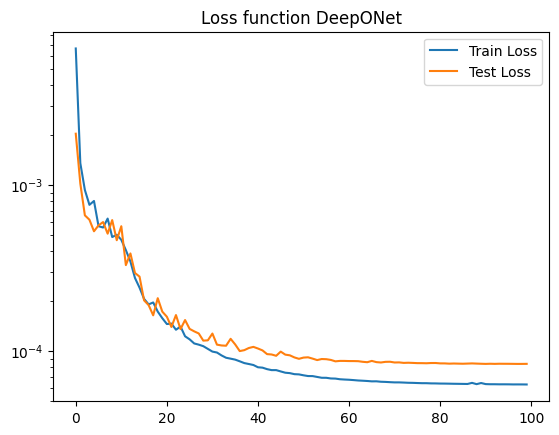

Final Testing Loss: 8.36759735980267e-05
Final Training Loss: 6.286212049402834e-05


<Figure size 640x480 with 0 Axes>

In [140]:
# Train DeepONet
deeponet, deeponet_train_loss_arr, deeponet_test_loss_arr = model_trainer(deeponet, trainData, testData, \
                                                         deeponet_config.epochs, sim_config.batch_size, \
                                                         deeponet_config.gamma, deeponet_config.learning_rate,\
                                                         deeponet_config.weight_decay,\
                                                         "../models/UnicycleConstDelayModels/deeponet")
evaluate_train_performance(deeponet, deeponet_config.model_type, deeponet_train_loss_arr, deeponet_test_loss_arr)

Epoch Time Train Loss Test Loss
Total epochs 100
0 3.544557809829712 0.023493662721570083 0.0022780013137630056
5 3.5126333236694336 0.0005827922394739457 0.0005859131753880768
10 3.527271032333374 0.0004607339149864546 0.0004225625679181475
15 3.5375897884368896 0.00030648812352221453 0.0002867551214414619
20 3.518238067626953 0.00019728739883266406 0.00020272419640114382
25 3.5137665271759033 0.00016699227215254887 0.00018985967437315377
30 3.5117270946502686 0.00015144016725566572 0.00017005702725977505
35 3.5179877281188965 0.00014187050479032897 0.00016080768638482642
40 3.275104522705078 0.00013569095781074835 0.00015435543207873014
45 3.5287303924560547 0.00013139024371958252 0.00015152418962402625
50 3.5290770530700684 0.0001282089924288117 0.0001492234192223155
55 3.537503242492676 0.00012612444612583837 0.00014874921572978595
60 3.5351009368896484 0.0001247099197427159 0.00014634280985716493
65 3.5169026851654053 0.0001236396407938875 0.00014563019298264638
70 3.5150437355041

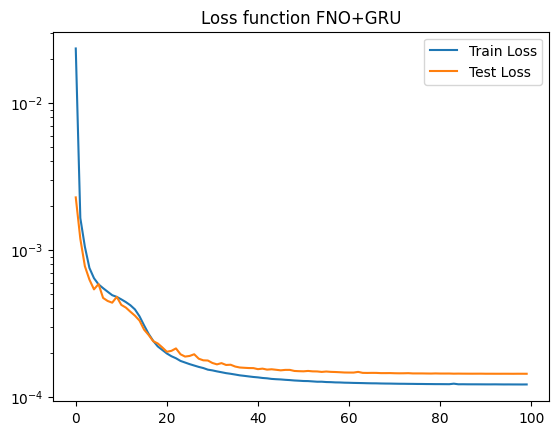

Final Testing Loss: 0.00014358727102738893
Final Training Loss: 0.0001214714468900651


<Figure size 640x480 with 0 Axes>

In [141]:
# Train fno_gru
fno_gru, fno_gru_train_loss_arr, fno_gru_test_loss_arr = model_trainer(fno_gru, trainData, testData, \
                                                         fno_gru_config.epochs, sim_config.batch_size, \
                                                         fno_gru_config.gamma, fno_gru_config.learning_rate,\
                                                         fno_gru_config.weight_decay, \
                                                         "../models/UnicycleConstDelayModels/fnogru")
evaluate_train_performance(fno_gru, fno_gru_config.model_type, fno_gru_train_loss_arr, fno_gru_test_loss_arr)

Epoch Time Train Loss Test Loss
Total epochs 100
0 2.1482393741607666 0.00844974981649443 0.001568947772731975
5 1.9692294597625732 0.0006452652745773489 0.0005822110702172809
10 1.9808566570281982 0.0004432295537164987 0.00041260347227632465
15 1.9808285236358643 0.0002452944768968015 0.0002227972592721464
20 1.970987319946289 0.00015445792364977221 0.00017090466973881813
25 1.9710562229156494 0.00012386484911591295 0.00015512129943494478
30 1.9658899307250977 0.00010849276104167895 0.0001210406893704434
35 2.0991051197052 9.627998086500711e-05 0.00011572305722063267
40 2.085981845855713 9.030016478599582e-05 0.00010592484010437998
45 2.091224193572998 8.569052147282122e-05 0.00010569985814014678
50 2.0939993858337402 8.291201699081789e-05 0.00010139218714371848
55 2.076356887817383 8.060358625893896e-05 0.0001006288744281933
60 2.074427366256714 7.929534434262216e-05 9.867982982310451e-05
65 2.0867855548858643 7.843449392781835e-05 9.755794093911795e-05
70 2.070674180984497 7.7590007

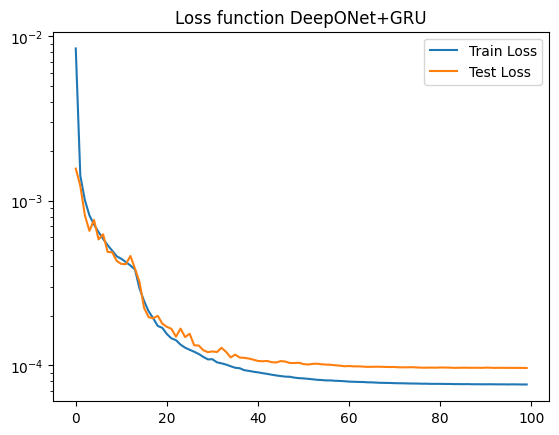

Final Testing Loss: 9.599983480704454e-05
Final Training Loss: 7.617564812820771e-05


<Figure size 640x480 with 0 Axes>

In [170]:
# Train deeponet_gru
deeponet_gru, deeponet_gru_train_loss_arr, deeponet_gru_test_loss_arr = model_trainer(deeponet_gru, trainData, testData, \
                                                          deeponet_gru_config.epochs, sim_config.batch_size, \
                                                          deeponet_gru_config.gamma, deeponet_gru_config.learning_rate,\
                                                          deeponet_gru_config.weight_decay, \
                                                           "../models/UnicycleConstDelayModels/deeponetgru")
evaluate_train_performance(deeponet_gru, deeponet_gru_config.model_type, deeponet_gru_train_loss_arr, deeponet_gru_test_loss_arr)

### Load our trained models
Either load the pretrained models on hugging face or the trained models from the previous cells. 

In [171]:
# Load models, note the incompatible keys is due to the NeuralOperator package and torch load. This can be ignored. 

fno.load_state_dict(torch.load("../models/UnicycleConstDelayModels/" + fno_config.model_filename, weights_only=False), strict=False)
deeponet.load_state_dict(torch.load("../models/UnicycleConstDelayModels/" + deeponet_config.model_filename, weights_only=True))
fno_gru.load_state_dict(torch.load("../models/UnicycleConstDelayModels/" + fno_gru_config.model_filename, weights_only=False), strict=False)
deeponet_gru.load_state_dict(torch.load("../models/UnicycleConstDelayModels/" + deeponet_gru_config.model_filename, weights_only=True), strict=False)

<All keys matched successfully>

### Evaluate our trained models
This is split into three parts:
 - Evaluate our trained models over the dataset (make sure you load the dataset above first)
 - 25 random trajectories
 - Computational time

In [172]:
fno_train_error, fno_test_error = evaluate_model(fno, fno_config.model_type, trainData, testData)
deeponet_train_error, deeponet_test_error = evaluate_model(deeponet, deeponet_config.model_type, trainData, testData)
fno_gru_train_error, fno_gru_test_error = evaluate_model(fno_gru, fno_gru_config.model_type, trainData, testData)
deeponet_gru_train_error, deeponet_gru_test_error = evaluate_model(deeponet_gru, deeponet_gru_config.model_type, trainData, testData)

In [173]:
model_names = ["FNO", "DeepONet", "FNO+GRU", "DeepONet+GRU"]
train_losses = [fno_train_error, deeponet_train_error, fno_gru_train_error, deeponet_gru_train_error]
test_losses = [fno_test_error, deeponet_test_error, fno_gru_test_error, deeponet_gru_test_error]

# Header
print(f"{'Model':<15} {'Train Loss':<12} {'Test Loss':<10}")
print("-" * 39)

# Rows
for model, train, test in zip(model_names, train_losses, test_losses):
    print(f"{model:<15} {train:<12.6f} {test:<10.6f}")

Model           Train Loss   Test Loss 
---------------------------------------
FNO             0.000043     0.000065  
DeepONet        0.000063     0.000084  
FNO+GRU         0.000121     0.000144  
DeepONet+GRU    0.000076     0.000096  


#### Evaluate over 25 trajectories
This may take some time to evaluate. Choose a value < 25 for faster performance. 

In [321]:
def sim_trajectories(num_trajs, init_cond_randomization_variance, delay_randomization_variance, model, predictor_func, sim_config, verbose=True):
    best_prediction_error = np.inf
    worst_prediction_error = 0
    best_prediction_ic = None
    worst_prediction_ic = None
    best_delay = None
    worst_delay = None
    prediction_error_arr = []
    np.random.seed(sim_config.random_state)
    for i in range(num_trajs):
        init_cond = np.array([1, 1, 1]) + np.random.uniform(-init_cond_randomization_variance, init_cond_randomization_variance, size=3)
        D = np.random.uniform(1, 1+delay_randomization_variance)
        u_delay, control_delay, pde, predictors = simulate_system_const_delay(init_cond, sim_config.dt, sim_config.T, sim_config.dx, D,predictor_func, model)
        prediction_error = np.mean(np.linalg.norm(predictors[0:-sim_config.nD+2, -1]-u_delay[sim_config.nD-2:], axis=1))
        prediction_error_arr.append(prediction_error)
        if prediction_error < best_prediction_error:
            best_prediction_ic = init_cond
            best_prediction_error = prediction_error
            best_delay = D
        if prediction_error > worst_prediction_error:
            worst_prediction_ic = init_cond
            worst_prediction_error = prediction_error
            worst_delay = D
    avg_prediction_error = np.mean(np.array(prediction_error_arr))
    return best_prediction_ic, best_delay, worst_prediction_ic, worst_delay, avg_prediction_error

In [324]:
# FNO
best_ic_fno, best_delay_fno, worst_ic_fno, worst_delay_fno, prediction_error_fno = \
    sim_trajectories(25, 0.1, 0.1, fno, ml_predictor, sim_config, True)

In [325]:
# deeponet
best_ic_deeponet, best_delay_deeponet, worst_ic_deeponet, worst_delay_deeponet, prediction_error_deeponet = \
    sim_trajectories(25, 0.1, 0.1, deeponet, ml_predictor, sim_config, True)

In [326]:
# fnogru
best_ic_fno_gru, best_delay_fno_gru, worst_ic_fno_gru, worst_delay_fno_gru, prediction_error_fno_gru = \
    sim_trajectories(25, 0.1, 0.1, fno_gru, ml_predictor, sim_config, True)

In [327]:
# deeponet_gru
best_ic_deeponet_gru, best_delay_deeponet_gru, worst_ic_deeponet_gru, worst_delay_deeponet_gru, prediction_error_deeponet_gru = \
    sim_trajectories(25, 0.1, 0.1, deeponet_gru, ml_predictor, sim_config, True)

In [328]:
# numerical
_, _, _, _, prediction_error_numerical = \
    sim_trajectories(25, 0.1, 0.1, None, None, sim_config, True)

In [330]:
model_names = ["FNO", "DeepONet", "FNO+GRU", "DeepONet+GRU", "Numerical"]
prediction_errors = [prediction_error_fno, prediction_error_deeponet, prediction_error_fno_gru,\
                     prediction_error_deeponet_gru, prediction_error_numerical]

# Header
print(f"{'Model':<15} {'Avg. Prediction Error':<20}")
print("-" * 65)

# Rows
for model, error in zip(model_names, prediction_errors):
    print(f"{model:<15} {error:<20.6f}")

Model           Avg. Prediction Error
-----------------------------------------------------------------
FNO             0.061683            
DeepONet        0.058748            
FNO+GRU         0.173268            
DeepONet+GRU    0.156601            
Numerical       0.028543            


#### FNO Qualatative plots

In [331]:
# Simulate FNO best case example
fno_best_states, fno_best_controls, _, fno_best_predictors = \
simulate_system_const_delay(best_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, best_delay_fno, ml_predictor, fno)
numerical_best_states, numerical_best_controls, _, numerical_best_predictors  = \
simulate_system_const_delay(best_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, best_delay_fno)

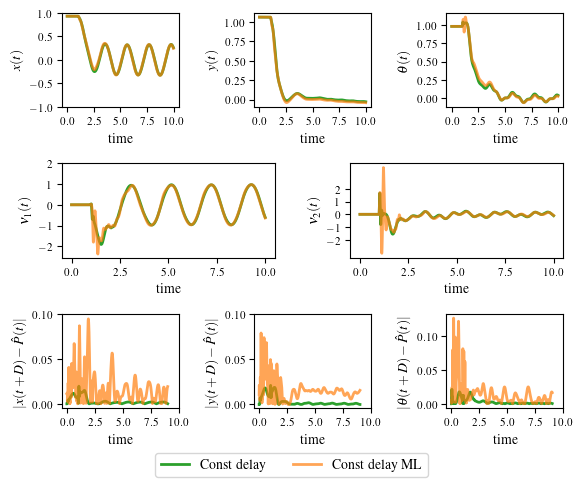

In [332]:
# Plot FNO Best Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_best_states,  fno_best_states, \
                            numerical_best_controls, fno_best_controls, \
                            numerical_best_predictors, fno_best_predictors,\
                            sim_config.nD, None)

In [333]:
# Simulate FNO worst case example
fno_worst_states, fno_worst_controls, _, fno_worst_predictors = \
simulate_system_const_delay(worst_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_fno, ml_predictor, fno)
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors  = \
simulate_system_const_delay(worst_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_fno)

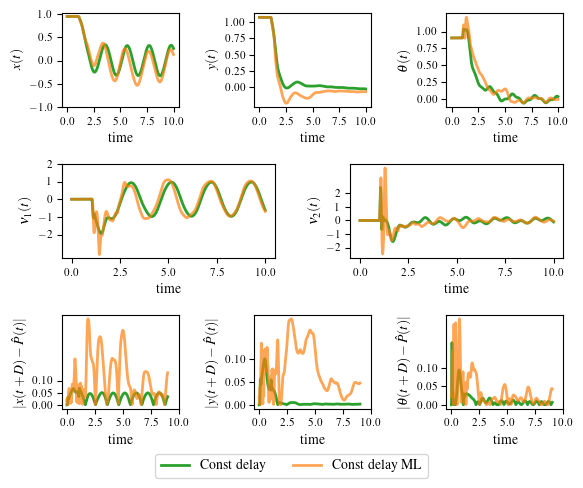

In [336]:
# Plot FNO worst Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_worst_states,  fno_worst_states, numerical_worst_controls, fno_worst_controls,\
                            numerical_worst_predictors, fno_worst_predictors, sim_config.nD)

#### DeepONet Qualatative plots

In [ ]:
# Simulate deeponet best case example
deeponet_best_states, deeponet_best_controls, _, deeponet_best_predictors = \
simulate_system_const_delay(best_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, best_delay_deeponet, ml_predictor, deeponet)
numerical_best_states, numerical_best_controls, _, numerical_best_predictors  = \
simulate_system_const_delay(best_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, best_delay_deeponet)

In [ ]:
# Plot deeponet Best Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_best_states,  deeponet_best_states, numerical_best_controls, deeponet_best_controls, None)

In [ ]:
# Simulate deeponet worst case example
deeponet_worst_states, deeponet_worst_controls, _, deeponet_worst_predictors = \
simulate_system_const_delay(worst_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_deeponet, ml_predictor, deeponet)
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors  = \
simulate_system_const_delay(worst_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_deeponet)

In [ ]:
# Plot deeponet worst Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_worst_states,  deeponet_worst_states, numerical_worst_controls, deeponet_worst_controls, None)

#### FNO+GRU Qualatative plots

In [ ]:
# Simulate fno_gru best case example
fno_gru_best_states, fno_gru_best_controls, _, fno_gru_best_predictors = \
simulate_system_const_delay(best_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, best_delay_fno_gru, ml_predictor, fno_gru)
numerical_best_states, numerical_best_controls, _, numerical_best_predictors  = \
simulate_system_const_delay(best_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, best_delay_fno_gru)

In [ ]:
# Plot fno_gru Best Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_best_states,  fno_gru_best_states, numerical_best_controls, fno_gru_best_controls, None)

In [ ]:
# Simulate fno_gru worst case example
fno_gru_worst_states, fno_gru_worst_controls, _, fno_gru_worst_predictors = \
simulate_system_const_delay(worst_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_fno_gru, ml_predictor, fno_gru)
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors  = \
simulate_system_const_delay(worst_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_fno_gru)

In [ ]:
# Plot fno_gru worst Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_worst_states,  fno_gru_worst_states, numerical_worst_controls, fno_gru_worst_controls, None)

#### DeepONet+GRU Qualatative plots

In [ ]:
# Simulate deeponet_gru best case example
deeponet_gru_best_states, deeponet_gru_best_controls, _, deeponet_gru_best_predictors = \
simulate_system_const_delay(best_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, best_delay_deeponet_gru, ml_predictor, deeponet_gru)
numerical_best_states, numerical_best_controls, _, numerical_best_predictors  = \
simulate_system_const_delay(best_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, best_delay_deeponet_gru)

In [ ]:
# Plot deeponet_gru Best Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_best_states,  deeponet_gru_best_states, numerical_best_controls, deeponet_gru_best_controls, None)

In [ ]:
# Simulate deeponet_gru worst case example
deeponet_gru_worst_states, deeponet_gru_worst_controls, _, deeponet_gru_worst_predictors = \
simulate_system_const_delay(worst_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_deeponet_gru, ml_predictor, deeponet_gru)
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors  = \
simulate_system_const_delay(worst_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, worst_delay_deeponet_gru)

In [ ]:
# Plo  t deeponet_gru worst Trajectory
plot_trajectory_with_errors(sim_config.t, numerical_worst_states,  deeponet_gru_worst_states, numerical_worst_controls, deeponet_gru_worst_controls, None)

In [27]:
# Get speedups across both Delay length and dt
model = deeponetProjected(16,2, 12,6,3)
num_sims = 1000
# dt = 0.01
# dt = 0.005
# dt = 0.001
# dt = 0.0005
start_times_numerical = np.zeros((4))
end_times_numerical = np.zeros((4))
start_times_ml = np.zeros((4))
end_times_ml = np.zeros((4))

# D=1, dt=0.01
D = 1
dt = 0.01
x = np.arange(0, 1, dt)
cur_state = np.random.uniform(size=3)
start_times_numerical[0] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    predictor_const_delay(cur_state, control_inp, D, x)
end_times_numerical[0] = time.time()

start_times_ml[0] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    ml_predictor_rnn(cur_state, control_inp, D, x, model)
end_times_ml[0] = time.time()

# D=1, dt=0.005
D = 1
dt = 0.005
x = np.arange(0, 1, dt)
cur_state = np.random.uniform(size=3)
start_times_numerical[1] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    predictor_const_delay(cur_state, control_inp, D, x)
end_times_numerical[1] = time.time()

start_times_ml[1] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    ml_predictor_rnn(cur_state, control_inp, D, x, model)
end_times_ml[1] = time.time()

# D=1, dt=0.001
D = 1
dt = 0.001
x = np.arange(0, 1, dt)
cur_state = np.random.uniform(size=3)
start_times_numerical[2] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    predictor_const_delay(cur_state, control_inp, D, x)
end_times_numerical[2] = time.time()

start_times_ml[2] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    ml_predictor_rnn(cur_state, control_inp, D, x, model)
end_times_ml[2] = time.time()

# D=1, dt=0.001
D = 1
dt = 0.0005
x = np.arange(0, 1, dt)
cur_state = np.random.uniform(size=3)
start_times_numerical[3] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    predictor_const_delay(cur_state, control_inp, D, x)
end_times_numerical[3] = time.time()

start_times_ml[3] = time.time()
for i in range(num_sims):
    cur_state = np.random.uniform(size=3)
    control_inp = np.random.uniform(size=(len(x), 2))
    ml_predictor_rnn(cur_state, control_inp, D, x, model)
end_times_ml[3] = time.time()

In [28]:
times_numerical = end_times_numerical - start_times_numerical
times_ml = end_times_ml - start_times_ml

# Labels
col_labels = ["dt=0.01", "dt=0.005", "dt=0.001", "dt=0.0005"]

# Combine row labels with matrix data

# Print pretty table
print("Numerical times")
formatted_row = [[f"{val:.2f}" for val in times_numerical]]
print(tabulate(formatted_row, headers=col_labels, tablefmt="grid"))

print("Ml times")
formatted_row = [[f"{val:.2f}" for val in times_ml]]
print(tabulate(formatted_row, headers=col_labels, tablefmt="grid"))

print("Speedup")
formatted_row = [[f"{val:.2f}" for val in times_numerical/times_ml]]
print(tabulate(formatted_row, headers=col_labels, tablefmt="grid"))

Numerical times
+-----------+------------+------------+-------------+
|   dt=0.01 |   dt=0.005 |   dt=0.001 |   dt=0.0005 |
+===========+============+============+=============+
|      1.99 |       4.12 |      23.09 |       50.43 |
+-----------+------------+------------+-------------+
Ml times
+-----------+------------+------------+-------------+
|   dt=0.01 |   dt=0.005 |   dt=0.001 |   dt=0.0005 |
+===========+============+============+=============+
|       1.1 |       1.11 |       1.23 |        1.48 |
+-----------+------------+------------+-------------+
Speedup
+-----------+------------+------------+-------------+
|   dt=0.01 |   dt=0.005 |   dt=0.001 |   dt=0.0005 |
+===========+============+============+=============+
|      1.81 |       3.72 |      18.76 |       34.18 |
+-----------+------------+------------+-------------+
